<a href="https://colab.research.google.com/github/alex-smith-uwec/NLP_Spring2025/blob/main/StateUnion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install datasets -q

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset
from collections import Counter

import nltk
from nltk.draw.dispersion import dispersion_plot

In [31]:
# Load the dataset
dataset = load_dataset("jsulz/state-of-the-union-addresses")

# Extract the necessary columns
dates = [item["date"] for item in dataset["train"]]
texts = [item["lemmatized"] for item in dataset["train"]]

# Combine dates and texts, then sort by dates
sorted_data = sorted(zip(dates, texts), key=lambda x: x[0])
sorted_dates, sorted_texts = zip(*sorted_data)

# Convert back to lists if needed
sorted_dates = list(sorted_dates)

# Replace dates with just the year
sorted_years = [date.year for date in sorted_dates]
sorted_texts = list(sorted_texts)



In [28]:
print(f"{sorted_years[2]}")
len(sorted_texts[2])

1791


956

In [5]:
# Verify the sorting
print(sorted_dates[-2:])

[Timestamp('2023-02-07 00:00:00'), Timestamp('2024-03-07 00:00:00')]


In [6]:
# Tokenize all texts and count word frequencies
all_words = []
for text in sorted_texts:
    # text is a list of words, so we can directly extend all_words
    all_words.extend(text)
word_counts = Counter(all_words)

In [7]:
all_words[0:10]

['embrace',
 'great',
 'satisfaction',
 'opportunity',
 'present',
 'congratulate',
 'present',
 'favorable',
 'prospect',
 'public']

In [8]:
# Get the most common words (excluding stopwords, if desired)
most_common_words = [word for word, freq in word_counts.most_common(10)]  # Adjust '10' for desired number

# Print the most common words
print("Most Common Words:", most_common_words)

# Prepare data for the lexical dispersion plot
word_occurrences = {word: [] for word in most_common_words}

for i, text in enumerate(texts):
    # text is already a list of tokens, no need to split
    tokens = text
    for word in most_common_words:
        word_occurrences[word].append(tokens.index(word) if word in tokens else None)



Most Common Words: ['state', 'government', 'year', 'make', 'congress', 'country', 'people', 'great', 'would', 'united']


In [13]:
focus_words=["science","war","waste","technology","god","fraud","woman","slave"]

<Figure size 1200x900 with 0 Axes>

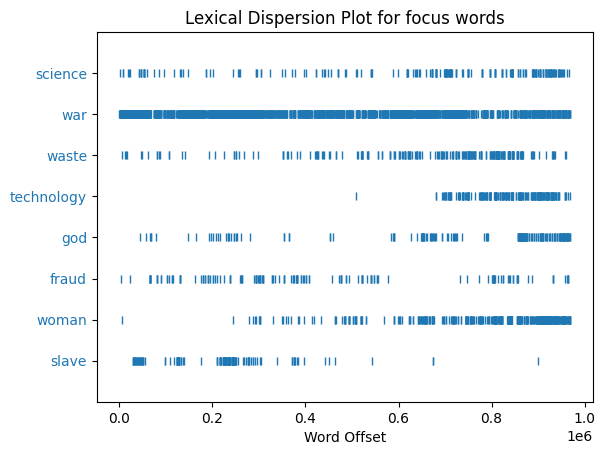

In [15]:
plt.figure(figsize=(12, 9))
dispersion_plot(all_words, focus_words, ignore_case=True, title='Lexical Dispersion Plot for focus words')
plt.show()

<Figure size 1200x900 with 0 Axes>

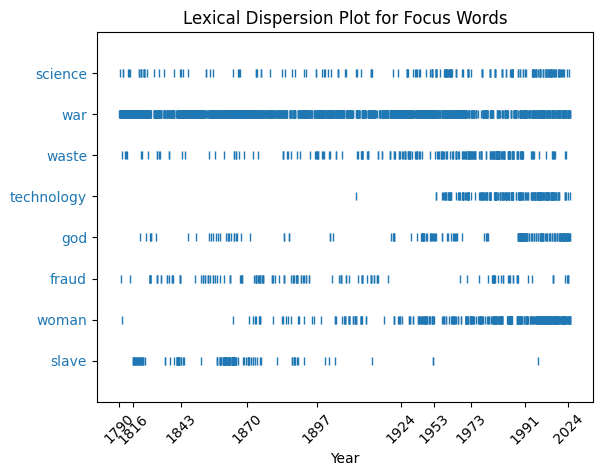

In [39]:


# Compute the lengths of each text
text_lengths = [len(text) for text in sorted_texts]

# Compute cumulative offsets
cumulative_offsets = np.cumsum([0] + text_lengths[:-1])  # Start at 0 for the first year

# Determine indices for approximately 25 evenly spaced ticks
num_ticks = 10
indices = np.linspace(0, len(cumulative_offsets) - 1, num=num_ticks, dtype=int)

# Subset offsets and years for tick marks
selected_offsets = cumulative_offsets[indices]
selected_years = [sorted_years[i] for i in indices]

# Plot with updated axis
plt.figure(figsize=(12, 9))
dispersion_plot(all_words, focus_words, ignore_case=True, title='Lexical Dispersion Plot for Focus Words')

# Set the horizontal axis
plt.xticks(selected_offsets, selected_years, rotation=45)
plt.xlabel("Year")
plt.show()


In [36]:
text_lengths

[487,
 617,
 956,
 954,
 885,
 1328,
 923,
 1346,
 967,
 1020,
 689,
 624,
 1493,
 978,
 993,
 944,
 1339,
 1336,
 1123,
 1220,
 810,
 1141,
 1069,
 1467,
 1501,
 1004,
 1494,
 1547,
 1998,
 1988,
 2068,
 1569,
 2577,
 1936,
 2829,
 3670,
 4076,
 3461,
 2974,
 3337,
 4849,
 6956,
 3267,
 3561,
 3598,
 5972,
 7109,
 5601,
 5344,
 5367,
 6212,
 4247,
 3795,
 3955,
 3701,
 4351,
 7572,
 8537,
 7639,
 9961,
 3538,
 3862,
 6179,
 4613,
 4575,
 4959,
 5527,
 4940,
 6524,
 7779,
 5929,
 6639,
 3299,
 3990,
 2946,
 2830,
 4270,
 3446,
 5708,
 4849,
 3630,
 4182,
 3065,
 4651,
 4808,
 4633,
 5820,
 3219,
 5116,
 3820,
 5573,
 6338,
 6296,
 4805,
 3819,
 4290,
 9535,
 7306,
 2522,
 6404,
 6115,
 5557,
 7682,
 6503,
 6070,
 7812,
 7261,
 7471,
 5870,
 10229,
 11312,
 9517,
 9315,
 4589,
 7089,
 8343,
 11944,
 11272,
 13070,
 9213,
 6663,
 12904,
 11295,
 12142,
 1603,
 2009,
 3640,
 997,
 1738,
 2476,
 2317,
 1289,
 2745,
 2929,
 3268,
 3344,
 5187,
 4938,
 4285,
 4004,
 5459,
 2318,
 2963,
 2186